# Part 2: Poisson editing

For this second part we are going to use Poissong editing to edit an image and make it realistic trying to minimize an energy function using the gradient methods eem previously.

In [3]:
# Install if required
!python -m pip install opencv-python

In [1]:
import numpy as np
from PIL import Image 
import os
import cv2 as cv
import matplotlib.pyplot as plt
from math import sqrt
from IPython.display import clear_output, display

For this part of the lab we are going to use the previous methods to modify the face of Mona Lisa and then make it much more realistic than copy pasting.

#### **1. Complete the code required in the cells by following the comments provided in the code.**

**Read the images**

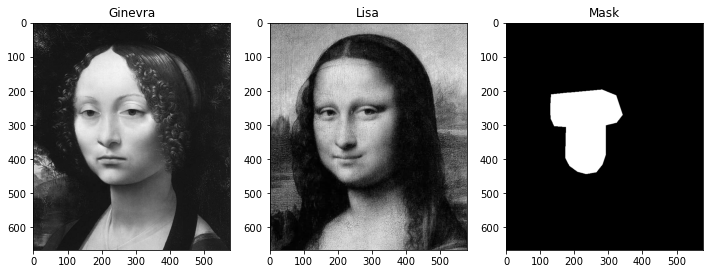

In [2]:
# Define the images directory
images_dir = os.path.abspath("../images")

# Read all the required images
ginevra = Image.open(os.path.join(images_dir, "ginevra.png"))
lisa = Image.open(os.path.join(images_dir, "lisa.png"))
mask = Image.open(os.path.join(images_dir, "mask.png"))

# Convert all the images to 2D
u1 = np.array(ginevra, dtype = float)[:, :, 0]
u2 = np.array(lisa, dtype = float)[:, :, 0]
mask = np.array(mask, dtype = float) / 255

# Show all the images
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 8))
ax1.imshow(u1, cmap = "gray")
ax1.set_title("Ginevra")
ax2.imshow(u2, cmap = "gray")
ax2.set_title("Lisa")
ax3.imshow(mask, cmap = "gray")
ax3.set_title("Mask")
plt.show()

**Apply filters to images**

Learn more about Gaussian blurring [here](https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html)


In [6]:
u1 = cv.GaussianBlur(src = u1, ksize = (9, 9), sigmaX = 2, borderType = cv.BORDER_REFLECT)
u2 = cv.GaussianBlur(src = u2, ksize = (11, 11), sigmaX = 4, borderType = cv.BORDER_REFLECT)

**Crude composition**

Just combining both pictures according to the predefined mask.

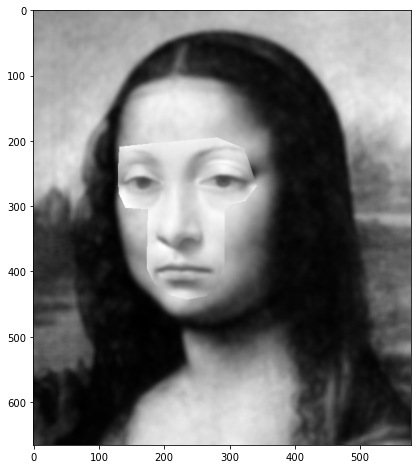

In [7]:
# TODO: generate an image which is u1 when mask = 1, and u2 when mask = 0
ucomp= mask*u1 + (1-mask)*u2

# Show the composed image
plt.figure(figsize = (12, 8))
plt.imshow(ucomp, cmap = "gray")

**Guiding vector field**

We compose the images, but at the gradient level!

In [8]:
def im_fwd_gradient(image: np.matrix):
    """
    Discrete gradient of an image using forward differences, with homogeneous Neuman boundary conditions.

    :param u: image (MxN)
            
    :return gradu_j: partial derivative in the j (rows) direction (also x direction)
    :return gradu_i: partial derivative in the i (cols) direction (also y direction)
    """
    # Get the size of the image
    image_shape = image.shape
    
    # Calculate both gradients
    gradu_j = np.append(np.diff(image, axis = 1), np.zeros((image_shape[0], 1)), axis = 1)
    gradu_i = np.append(np.diff(image, axis = 0), np.zeros((1, image_shape[1])), axis = 0)
    return gradu_i, gradu_j

In [9]:
# TODO: Compute the gradients of u1 and u2, and define a new gradient [vj,vi] 
#       which corresponds to the gradient of u1 when mask = 1, and the gradient 
#       of u2 when mask = 0

# Compute the gradient of the images
gu1i, gu1j = im_fwd_gradient(u1)
gu2i, gu2j = im_fwd_gradient(u2)

# Calculate v
vi= mask * gu1i + (1-mask)* gu2i
vj=mask*gu1j + (1-mask)* gu2j

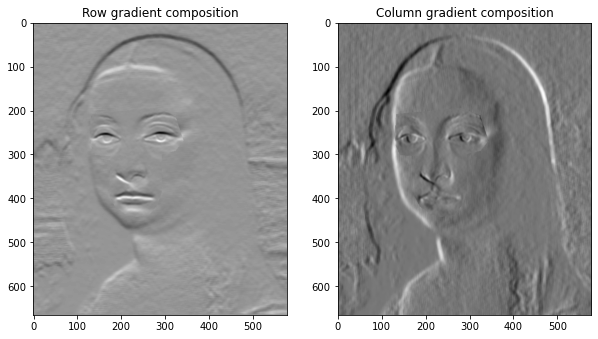

In [12]:
#Show the gradient composition
fig, (ax1,ax2)= plt.subplots(nrows=1, ncols=2, figsize=(10,8))
ax1.imshow(vi, cmap= 'gray')
ax1.set_title('Row gradient composition')
ax2.imshow(vj,cmap='gray')
ax2.set_title('Column gradient composition')
plt.show()


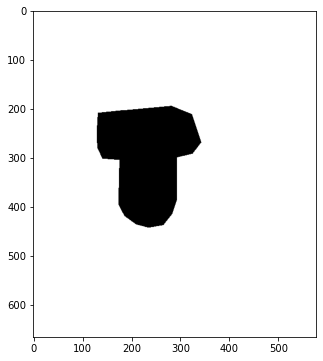

In [13]:
#Show the mask
plt.figure(figsize=(8,6))
plt.imshow((1-mask),cmap='gray')

**Conjugate gradient set up**

In [14]:
def im_bwd_divergence(gradient_i: np.matrix,
                      gradient_j: np.matrix):
    """
    Discrete divergence of a vector field using backwards differences. 
    This is the negative transpose of the im_fwd_gradient
    
    :param gradient_i: component of g in the direction j (rows) (also x direction)
    :param gradient_j: component of g in the direction i (cols) (also y direction)
    
    :return divg: backwards divergence of g
    """
    # Backwards j partial derivative of gradient_j
    gradient_j[:, gradient_j.shape[1] - 1] = 0
    divg = np.diff(np.append(np.zeros((gradient_j.shape[0], 1)), gradient_j, axis = 1), axis = 1)
    
    # Backwards i partial derivative of gradient_i
    gradient_i[gradient_i.shape[0] - 1, :] = 0
    divg = np.diff(np.append(np.zeros((1, gradient_i.shape[1])), gradient_i, axis = 0), axis = 0) + divg
    
    return divg

In [15]:
def poisson_linear_operator(u, beta):
    """
    Discrete laplacian of an image using a forward gradient and 
    a backward divergence. It computes the Laplacian inside a region indicated by a 
    mask (mask = 1). It assumes u(x) = 0 for x outside the mask (homogeneous
    Dirichlet boundary conditions). The interface is compatible with
    conjugate_gradient and gradient_descent.

    lap = im_laplacian_mask(u,prms)

    param u: image (MxN)
    param prms: structure with one field, prms.mask, a (MxN) binary image

    :return lap: laplacian
    """
    gu_i , gu_j = im_fwd_gradient(u)
    lapu = (-1) * im_bwd_divergence(gu_i, gu_j)
    return lapu + beta * u

In [16]:
def conjugate_gradient(callback,
                       b: np.matrix,
                       callback_params: dict,
                       initial_condition: np.matrix,
                       tolerance: float,
                       max_iters: int,
                       fig = None,
                       ax = None):
    """
    implementation of the conjugate gradient algorithm for the minimization of quadratic problems 

       f(x) = 1/2 x'Ax - bx. 

    It uses function handles. It requires a handle to a Python function that implements the product of matrix A with x.

    :param callback: handle (pointer) to a Python function implementing the product with matrix A. 
    :param callback_params: dictionary containing the params for the callback functions
    :param b: vector b, can be in matrix form (MxN)
    :param initial_conditions: initial condition, same dimensions as b (MxN)
    :param max_iters: maximum number of iterations
    :param tolerance: tolerance for the stopping condition (it stop when the norm of the gradient is below the tolerance)

    :return x: value found (MxN)
    :return fs: evolution of the target function (total_iters x 1 vector)
    """

    Ax = callback(initial_condition, **callback_params)
    r = Ax - b                        # TODO: compute residual (the gradient)
    nr = np.multiply(r,r).sum()                     # TODO: inner product of gradient
    d = -r.copy()                     # TODO: first descent direction is the negative grad.
    
    # Note: since the variables can be stored as matrices (for example, x is an image)
    #       we use np.multiply(x1, x2) to compute the dot products.

    # Allocate memory for vector of energy values of the iterates
    fs  = []
    current_value = initial_condition

    # Start loop 
    it = 0

    while (sqrt(nr) > tolerance) and (it < max_iters):
        # Increase iteration counter
        it = it + 1
        if it % 10 == 0:
            print("[{} of {}]\t-> |grad f(x)| = {}".format(it, max_iters, nr))

        # Compute quadratic energy f = .5 <Ax - b,x> - 0.5* <b,x>
        fs.append(0.5 * np.multiply(r, current_value).sum() - 0.5 * np.multiply(b, current_value).sum())

        # 1. TODO: line search in d - compute time step alpha
        Ad = callback(d, **callback_params)
        alpha = np.multiply(d,r).sum()/np.multiply(d,Ad).sum()
        
        previous_value = current_value # keep x_old - just for visualization

        #2. TODO: update point x
        current_value = current_value - alpha *d

        # compute new residual r = Ax - b
        Ax = callback(current_value, **callback_params)
        r = Ax - b                       # TODO: compute residual (the gradient)
        nr_old = nr                       # inner product of the old residual
        nr = np.multiply(r,r).sum()                      # TODO: squared norm of gradient

        # A-orthogonalization of r (Gram-Schmidt)
        # new search direction d is a linear combination of r and previous d
        # chosen so that it is A-orthogonal with the previous search directions
        beta_2 = nr/ nr_old
        d = -r.copy() + beta_2*d
        
        # ----- plot current position! Just for visualization purposes -----
        if current_value.shape == (2, 1):
            if not ax:
                fig, ax = plt.subplots()
            ax.plot(current_value[0, 0], current_value[1, 0], marker = 'o', color = "r")
            ax.plot([previous_value[0, 0], current_value[0, 0]], 
                    [previous_value[1, 0], current_value[1, 0]], "-r")
            clear_output(wait=True)
            display(fig) 
        elif current_value.shape[0] > 1 and current_value.shape[1] > 1:
            # if x is a matrix (an image) (visualization of denoising) 
            if it % 10 == 0:
                if not ax:
                    fig, ax = plt.subplots(figsize = (12, 8))
                ax.imshow(current_value, cmap = "gray")
                clear_output(wait=True)
                display(fig) 
                
    print("[{} of {}]\t-> |grad f(x)| = {}".format(it, max_iters, nr))
    return current_value, np.matrix(fs).T

#### **2. Once you have completed all the code above, now implemented into the function lisa_ginevra_test and explain with your own words the main steps of the algorithm**

In [47]:
def lisa_ginevra_test(u1: np.matrix, 
                      u2: np.matrix,
                      mask: np.matrix):
    """
    uses Poisson editing to interchange the faces of Ginevra de' Benci and Lisa Gherardini
    
    :param u1: Ginevra's image
    :param u2: Lisa's image
    """
    # TODO: CRUDE COMPOSITION
    ucomp = u1 * mask+u2 * (1-mask)
    
    # TODO: GUIDING VECTOR FIELD
    #gradient of the images
    gu1i, gu1j= im_fwd_gradient(u1)
    gu2i, gu2j= im_fwd_gradient(u2)
    
    # Calculate v
    vi= gu1i * mask + gu2i * (1-mask)
    vj= gu1j * mask + gu2j * (1-mask)
    
    # Define beta_0 and calculate beta
    beta_0 = 20                         # TRY CHANGING
    beta = beta_0 * (1 - mask)

    # Calculate the right hand term with bounday data
    b = (-1) * im_bwd_divergence(vi, vj) + beta * u2

    # Define the parameters to be used when calculating the conjugate gradient
    initial_condition = np.zeros_like(u1)+200  # TRY CHANGING    
    tolerance = 1                         # TRY CHANGING
    max_iters = 1000                    # TRY CHANGING
    upns, fs = conjugate_gradient(callback = poisson_linear_operator,
                                  b = b,
                                  callback_params = {"beta": beta},
                                  initial_condition = initial_condition,
                                  tolerance = tolerance,
                                  max_iters = max_iters)
    
    # Plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 8))
    ax1.imshow(u1, cmap = "gray")
    ax1.set_title("Ginevra")
    ax2.imshow(u2, cmap = "gray")
    ax2.set_title("Lisa")
    ax3.imshow(upns, cmap = "gray")
    ax3.set_title("composing gradients")
    ax4.imshow(ucomp, cmap = "gray")
    ax4.set_title("composing gray levels")
    plt.show()

The first thing that the algorithm does is to overlap the mask in the original face, so at the beggining this part is compltetly black. After this we compute the gradient of the photos calling im_fwd_gradient, since images are discrete we take the difference between points and apply some boundary conditions(Neuman).

Then we define Beta(parameter explained in the next exercise) and compute b, which is the vector we are refering in the equation Ax=b.

Finally we chose some initial conditions, run the conjugate_gradient which was defined before (minimizes the energy function defined in the pdf according to some of the parameters), and plot the results obtained.


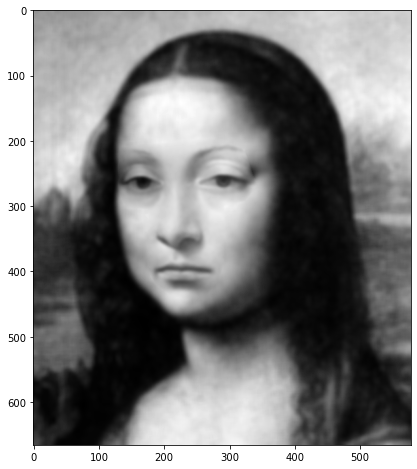

[450 of 1000]	-> |grad f(x)| = 0.9629209064958693


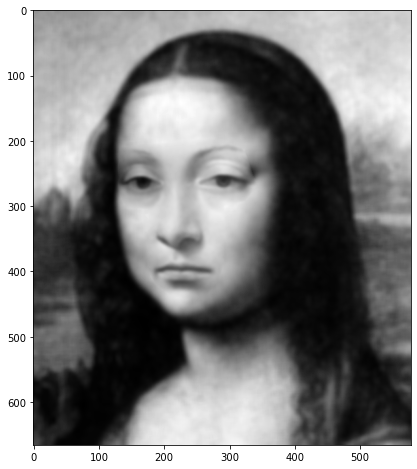

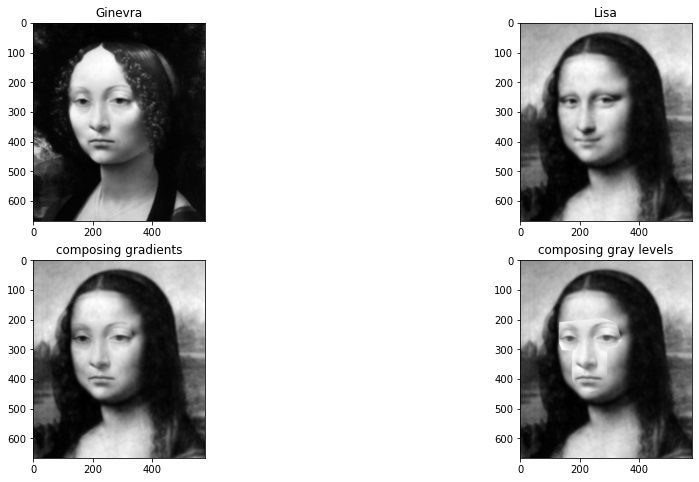

In [48]:
lisa_ginevra_test(u1, u2, mask)

#### **3. Run the function lisa_ginevra_test using different parameters and explain the differences**

**Max_iters:** just a limit for the max number of iteratons. If we set it very low the modified part will be black since the algorithm won't be able to minimize any function, but if you put a very big image, unless it is not stop by the tolerance, you will be a lot of almost impredecible changes at each iteration.

**Beta:** it is a coefficient image which controls the attachment to the original image. Inside the face B will be 0 since tha mask there is 1, so it defines the attachment outside the modifiied part, if beta is 0, the energy will be focused only on minimizing the regularization part while and generally will take more time to converge, while if its very the part of fidelity to the data will be more important and will converge in less time.

**Tolerance:** as we have seen in other labs, it stops the algorithm when the mod of the gradient is below it, a very large tolerance can make the algorithm to stop at its very first steps while a lower one will cause the algorithm to do extra steps which might not apport any appreciable change to the image.

**Initial_condition:** it is defined to change between different initial colors of the mask; the default one is black (with all 0) but you can increase the values and change the color (white for example). This will cmake that the photo starts clearer and gets darker or viceversa. As far as I see, the final output of the algorithm won't differ very much and the number of iteration of having the initial condition white in this case is lower but in another photo could be more.
